# **Amazon Employee Access Challenge (Part-1)**

##Business Problem

The objective of this challenge is to build a model learned using historical data, that will automatically determine whether an employee should be granted access or not based on the employee's role information and resource code.

##Label

ACTION is 1 if access is granted to the resource and 0 if not granted.

##Features



*   RESOURCE - An ID for each resource
*   MGR_ID - The EMPLOYEE ID of the manager of the current EMPLOYEE ID record. An employee may have only one manager at a time.
*   ROLE_ROLLUP_1 -  Company role grouping category id 1 (e.g. US Engineering)
*   ROLE_ROLLUP_2 - Company role grouping category id 2 (e.g. US Retail)
*   ROLE_DEPTNAME -	Company role department description (e.g. Retail)
*   ROLE_TITLE - Company role business title description (e.g. Senior Engineering Retail Manager)
*   ROLE_FAMILY_DESC - Company role family extended description (e.g. Retail 
Manager, Software Engineering)
*   ROLE_FAMILY - Company role family description (e.g. Retail Manager)
*   ROLE_CODE - Company role code; this code is unique to each role (e.g. Manager)


##Scoring Metric

Area Under ROC Curve. (AUC Score)

ROC Curve is a plot between TPR (True Positive Rate) and FPR (False Positive Rate)

*   TPR = TP/(TP + FN)

Percentage of approved access that are correctly predicted.
*   FPR = FP/(FP + TN)

Percentage of denied access that are incorrectly predicted.



In [ ]:
#Importing libraries
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [ ]:
#Reading data
data = pd.read_csv('train.csv')
data_test = pd.read_csv('test.csv')

#Exploratory Data Analysis (EDA)

In [ ]:
data.columns

Index(['ACTION', 'RESOURCE', 'MGR_ID', 'ROLE_ROLLUP_1', 'ROLE_ROLLUP_2',
       'ROLE_DEPTNAME', 'ROLE_TITLE', 'ROLE_FAMILY_DESC', 'ROLE_FAMILY',
       'ROLE_CODE'],
      dtype='object')

So, we have total 10 features here. Out of which 'ACTION' is our target variable.

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32769 entries, 0 to 32768
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   ACTION            32769 non-null  int64
 1   RESOURCE          32769 non-null  int64
 2   MGR_ID            32769 non-null  int64
 3   ROLE_ROLLUP_1     32769 non-null  int64
 4   ROLE_ROLLUP_2     32769 non-null  int64
 5   ROLE_DEPTNAME     32769 non-null  int64
 6   ROLE_TITLE        32769 non-null  int64
 7   ROLE_FAMILY_DESC  32769 non-null  int64
 8   ROLE_FAMILY       32769 non-null  int64
 9   ROLE_CODE         32769 non-null  int64
dtypes: int64(10)
memory usage: 2.5 MB


We have total 32769 data points to train our models. Let's check shape of test data as well.

In [ ]:
data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58921 entries, 0 to 58920
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   id                58921 non-null  int64
 1   RESOURCE          58921 non-null  int64
 2   MGR_ID            58921 non-null  int64
 3   ROLE_ROLLUP_1     58921 non-null  int64
 4   ROLE_ROLLUP_2     58921 non-null  int64
 5   ROLE_DEPTNAME     58921 non-null  int64
 6   ROLE_TITLE        58921 non-null  int64
 7   ROLE_FAMILY_DESC  58921 non-null  int64
 8   ROLE_FAMILY       58921 non-null  int64
 9   ROLE_CODE         58921 non-null  int64
dtypes: int64(10)
memory usage: 4.5 MB


We have total 58921 data points to test our models.

Let's explore the train dataset now.

In [ ]:
data.isna().sum()

ACTION              0
RESOURCE            0
MGR_ID              0
ROLE_ROLLUP_1       0
ROLE_ROLLUP_2       0
ROLE_DEPTNAME       0
ROLE_TITLE          0
ROLE_FAMILY_DESC    0
ROLE_FAMILY         0
ROLE_CODE           0
dtype: int64

There is no missing value present.

In [ ]:
data.duplicated().sum()

0

There is no duplicate row present.

In [ ]:
data.nunique(axis=0)

ACTION                 2
RESOURCE            7518
MGR_ID              4243
ROLE_ROLLUP_1        128
ROLE_ROLLUP_2        177
ROLE_DEPTNAME        449
ROLE_TITLE           343
ROLE_FAMILY_DESC    2358
ROLE_FAMILY           67
ROLE_CODE            343
dtype: int64

All the features are categorical here. And we can see that 'RESOURCE' feature have highest cardinality. Since, 'ACTION' variable have cardinality = 2 therefore its a binary classification problem.

##Univariate Analysis

Lets first analyze our target variable.

In [ ]:
data['ACTION'].value_counts()

1    30872
0     1897
Name: ACTION, dtype: int64

Its an imbalanced dataset. Lets visualize them.

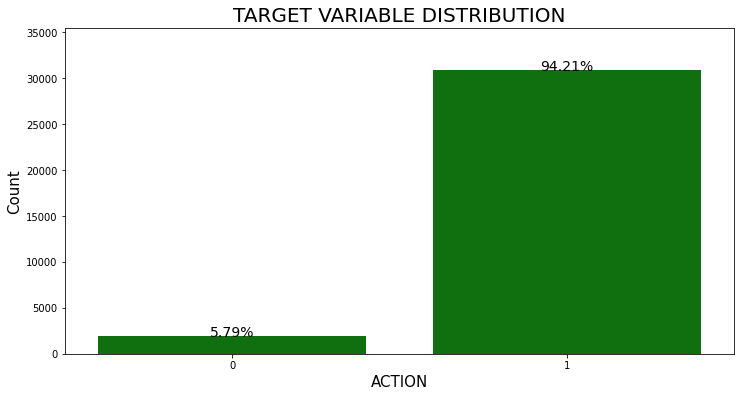

In [ ]:
#Code Source: https://www.kaggle.com/kabure/eda-feat-engineering-encode-conquer
total = len(data)
plt.figure(figsize=(12,6))

ax = sns.countplot(x='ACTION', data=data, color='green')
ax.set_title("TARGET VARIABLE DISTRIBUTION", fontsize = 20)
ax.set_xlabel("ACTION", fontsize = 15)
ax.set_ylabel("Count", fontsize = 15)

sizes=[] # Get highest values in y
for p in ax.patches:
    height = p.get_height()
    sizes.append(height)
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total*100),
            ha="center", fontsize=14) 
ax.set_ylim(0, max(sizes) * 1.15) # set y limit based on highest heights

plt.show()

Its highly imbalanced dataset with a ratio of 94:6. We will try oversampling to see if it improves our model performance.

Lets check the distribution of each categorical features

[Text(0, 0.5, 'Probability')]

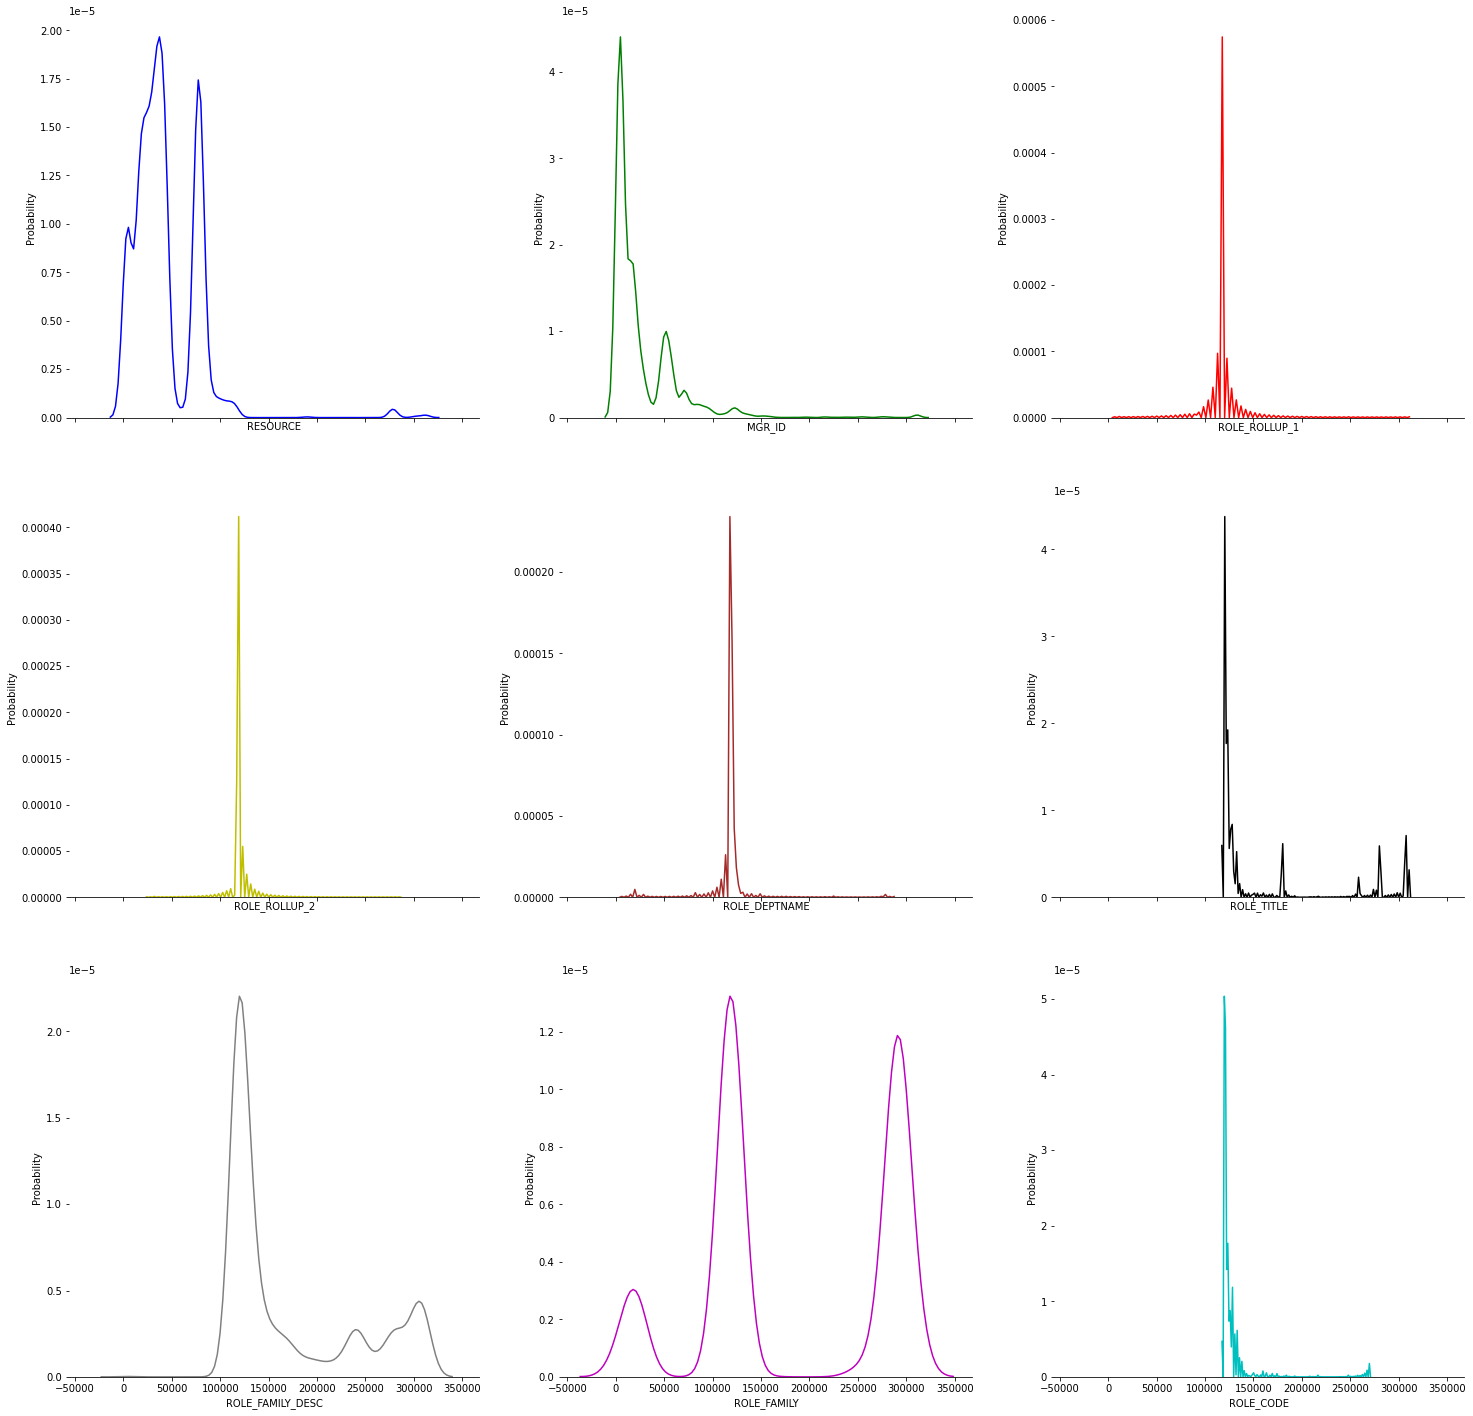

In [ ]:
# Set up the matplotlib figure
f, axes = plt.subplots(3,3, figsize=(25, 25), sharex=True)
sns.despine(left=True)

ax = sns.distplot(data['RESOURCE'], hist=False, color="b", ax=axes[0, 0])
ax.set(ylabel='Probability')
ax = sns.distplot(data['MGR_ID'], hist=False, color="g", ax=axes[0, 1])
ax.set(ylabel='Probability')
ax = sns.distplot(data['ROLE_ROLLUP_1'], hist=False, color="r", ax=axes[0, 2])
ax.set(ylabel='Probability')
ax = sns.distplot(data['ROLE_ROLLUP_2'], hist=False, color="y", ax=axes[1, 0])
ax.set(ylabel='Probability')
ax = sns.distplot(data['ROLE_DEPTNAME'], hist=False, color="brown", ax=axes[1, 1])
ax.set(ylabel='Probability')
ax = sns.distplot(data['ROLE_TITLE'], hist=False, color="k", ax=axes[1, 2])
ax.set(ylabel='Probability')
ax = sns.distplot(data['ROLE_FAMILY_DESC'], hist=False, color="grey", ax=axes[2, 0])
ax.set(ylabel='Probability')
ax = sns.distplot(data['ROLE_FAMILY'], hist=False, color="m", ax=axes[2, 1])
ax.set(ylabel='Probability')
ax = sns.distplot(data['ROLE_CODE'], hist=False, color="c", ax=axes[2, 2])
ax.set(ylabel='Probability')

From these graphs, we can observe that very less number of subcategory comprises of the whole category. Which means that despite having high cardinality, only top few subcategories are important.

Especially in features: ROLE_ROLLUP_1, ROLE_ROLLUP_2, ROLE_DEPTNAME, ROLE_TITLE, ROLE_CODE the top few subcategories are very dominant.



##Bivariate Analysis

Lets check ACTION wise distribution of these categories.

[Text(0, 0.5, 'Probability')]

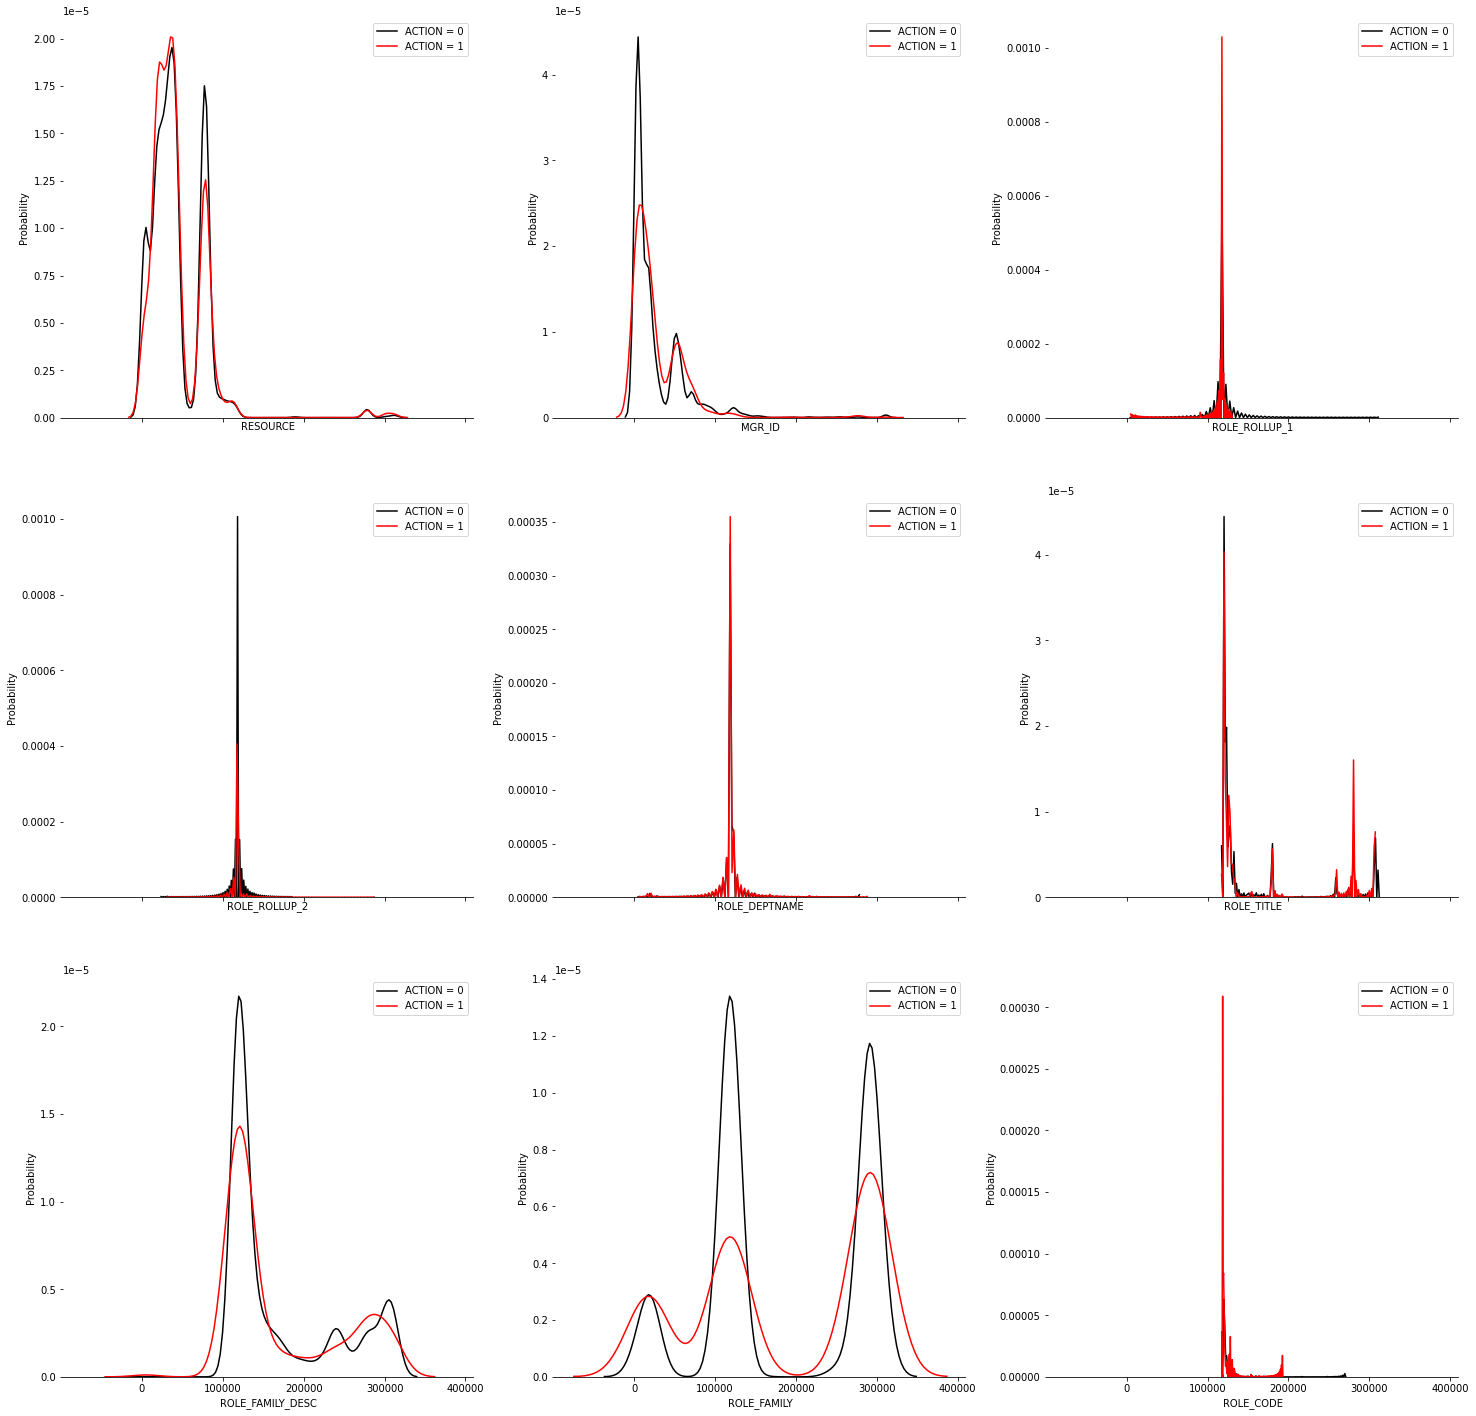

In [ ]:
# Set up the matplotlib figure
f, axes = plt.subplots(3,3, figsize=(25, 25), sharex=True)
sns.despine(left=True)

ax = sns.distplot(data[data['ACTION']==1]['RESOURCE'], hist=False, color="k", ax=axes[0, 0], label="ACTION = 0")
ax = sns.distplot(data[data['ACTION']==0]['RESOURCE'], hist=False, color="r", ax=axes[0, 0], label="ACTION = 1")
ax.set(ylabel='Probability')

ax = sns.distplot(data[data['ACTION']==1]['MGR_ID'], hist=False, color="k", ax=axes[0, 1], label="ACTION = 0")
ax = sns.distplot(data[data['ACTION']==0]['MGR_ID'], hist=False, color="r", ax=axes[0, 1], label="ACTION = 1")
ax.set(ylabel='Probability')

ax = sns.distplot(data[data['ACTION']==1]['ROLE_ROLLUP_1'], hist=False, color="k", ax=axes[0, 2], label="ACTION = 0")
ax = sns.distplot(data[data['ACTION']==0]['ROLE_ROLLUP_1'], hist=False, color="r", ax=axes[0, 2], label="ACTION = 1")
ax.set(ylabel='Probability')

ax = sns.distplot(data[data['ACTION']==1]['ROLE_ROLLUP_2'], hist=False, color="k", ax=axes[1, 0], label="ACTION = 0")
ax = sns.distplot(data[data['ACTION']==0]['ROLE_ROLLUP_2'], hist=False, color="r", ax=axes[1, 0], label="ACTION = 1")
ax.set(ylabel='Probability')

ax = sns.distplot(data[data['ACTION']==1]['ROLE_DEPTNAME'], hist=False, color="k", ax=axes[1, 1], label="ACTION = 0")
ax = sns.distplot(data[data['ACTION']==0]['ROLE_DEPTNAME'], hist=False, color="r", ax=axes[1, 1], label="ACTION = 1")
ax.set(ylabel='Probability')

ax = sns.distplot(data[data['ACTION']==1]['ROLE_TITLE'], hist=False, color="k", ax=axes[1, 2], label="ACTION = 0")
ax = sns.distplot(data[data['ACTION']==0]['ROLE_TITLE'], hist=False, color="r", ax=axes[1, 2], label="ACTION = 1")
ax.set(ylabel='Probability')

ax = sns.distplot(data[data['ACTION']==1]['ROLE_FAMILY_DESC'], hist=False, color="k", ax=axes[2, 0], label="ACTION = 0")
ax = sns.distplot(data[data['ACTION']==0]['ROLE_FAMILY_DESC'], hist=False, color="r", ax=axes[2, 0], label="ACTION = 1")
ax.set(ylabel='Probability')

ax = sns.distplot(data[data['ACTION']==1]['ROLE_FAMILY'], hist=False, color="k", ax=axes[2, 1], label="ACTION = 0")
ax = sns.distplot(data[data['ACTION']==0]['ROLE_FAMILY'], hist=False, color="r", ax=axes[2, 1], label="ACTION = 1")
ax.set(ylabel='Probability')

ax = sns.distplot(data[data['ACTION']==1]['ROLE_CODE'], hist=False, color="k", ax=axes[2, 2], label="ACTION = 0")
ax = sns.distplot(data[data['ACTION']==0]['ROLE_CODE'], hist=False, color="r", ax=axes[2, 2], label="ACTION = 1")
ax.set(ylabel='Probability')

We can observe here that the subcategories corresponding to ACTION = 0 are more in number than subcategories corresponding to ACTION = 1.

 This information will be helpful in modelling since we already have very less proportion of ACTION = 0 and then these dominant subcategories give a higher chance of ACTION to be equal to 0.

##Multi Variate Analysis

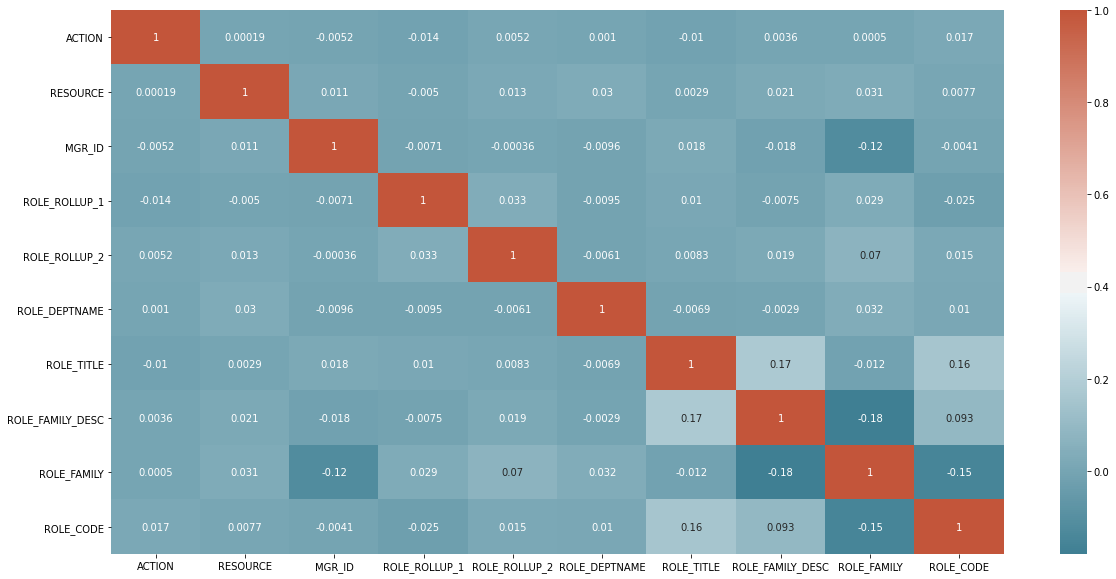

In [ ]:
#Lets plot correlation matrix
plt.figure(figsize=(20,10))
corr = data.corr()
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, annot=True, cmap=sns.diverging_palette(220, 20, as_cmap=True))

None of the features are highly correlated here. We can further analyze ROLE_TITLE vs ROLE_FAMILY_DESC, ROLE_CODE vs ROLE_TITLE, ROLE_FAMILY_DESC vs ROLE_FAMILY, ROLE_FAMILY vs ROLE_CODE, ROLE_FAMILY vs MGR_ID because of their slight correlation.

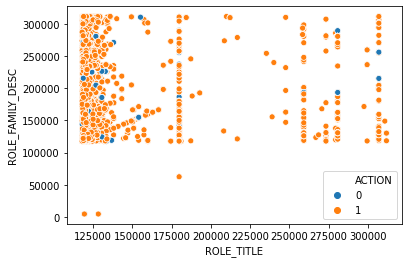

In [ ]:
#Scatter Plot between ROLE_TITLE and ROLE_FAMILY_DESC
sns.scatterplot('ROLE_TITLE', 'ROLE_FAMILY_DESC', data=data, hue = 'ACTION')

As expected, we can observe very little correlation here. ACTION values are also not seperated. Not any useful info here. Let's move on.

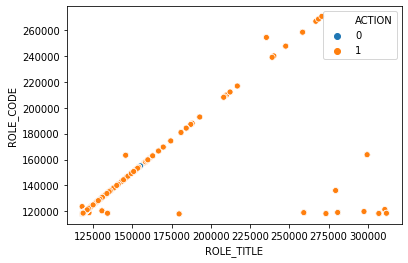

In [ ]:
#Scatter Plot between ROLE_TITLE and ROLE_CODE
sns.scatterplot('ROLE_TITLE', 'ROLE_CODE', data=data, hue = 'ACTION')

These two features are well correlated, we can ignore one of these features for our modelling. The ACTION values are not seperated.

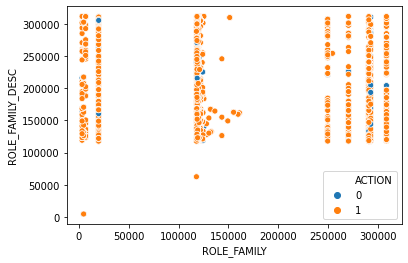

In [ ]:
#Scatter Plot between ROLE_FAMILY and ROLE_FAMILY_DESC
sns.scatterplot('ROLE_FAMILY', 'ROLE_FAMILY_DESC', data=data, hue = 'ACTION')

Can't observe any correlation here. ACTION values are also not seperated. Not any useful info here. Let's move on.

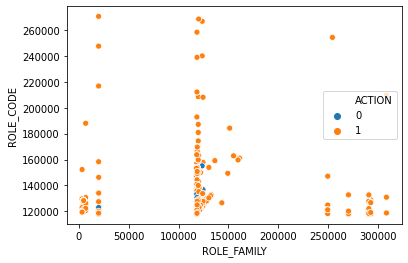

In [ ]:
#Scatter Plot between ROLE_FAMILY and ROLE_CODE
sns.scatterplot('ROLE_FAMILY', 'ROLE_CODE', data=data, hue = 'ACTION')

Can't observe any correlation here. ACTION values are also not seperated. Not any useful info here. Let's move on.

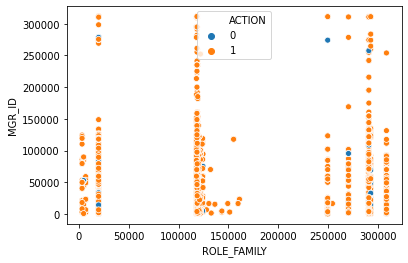

In [ ]:
#Scatter Plot between ROLE_FAMILY and MGR_ID
sns.scatterplot('ROLE_FAMILY', 'MGR_ID', data=data, hue = 'ACTION')

Can't observe any correlation here. ACTION values are also not seperated. Not any useful info here. Let's move on.

Let's try pairplot as well just to see if we missed anything useful.

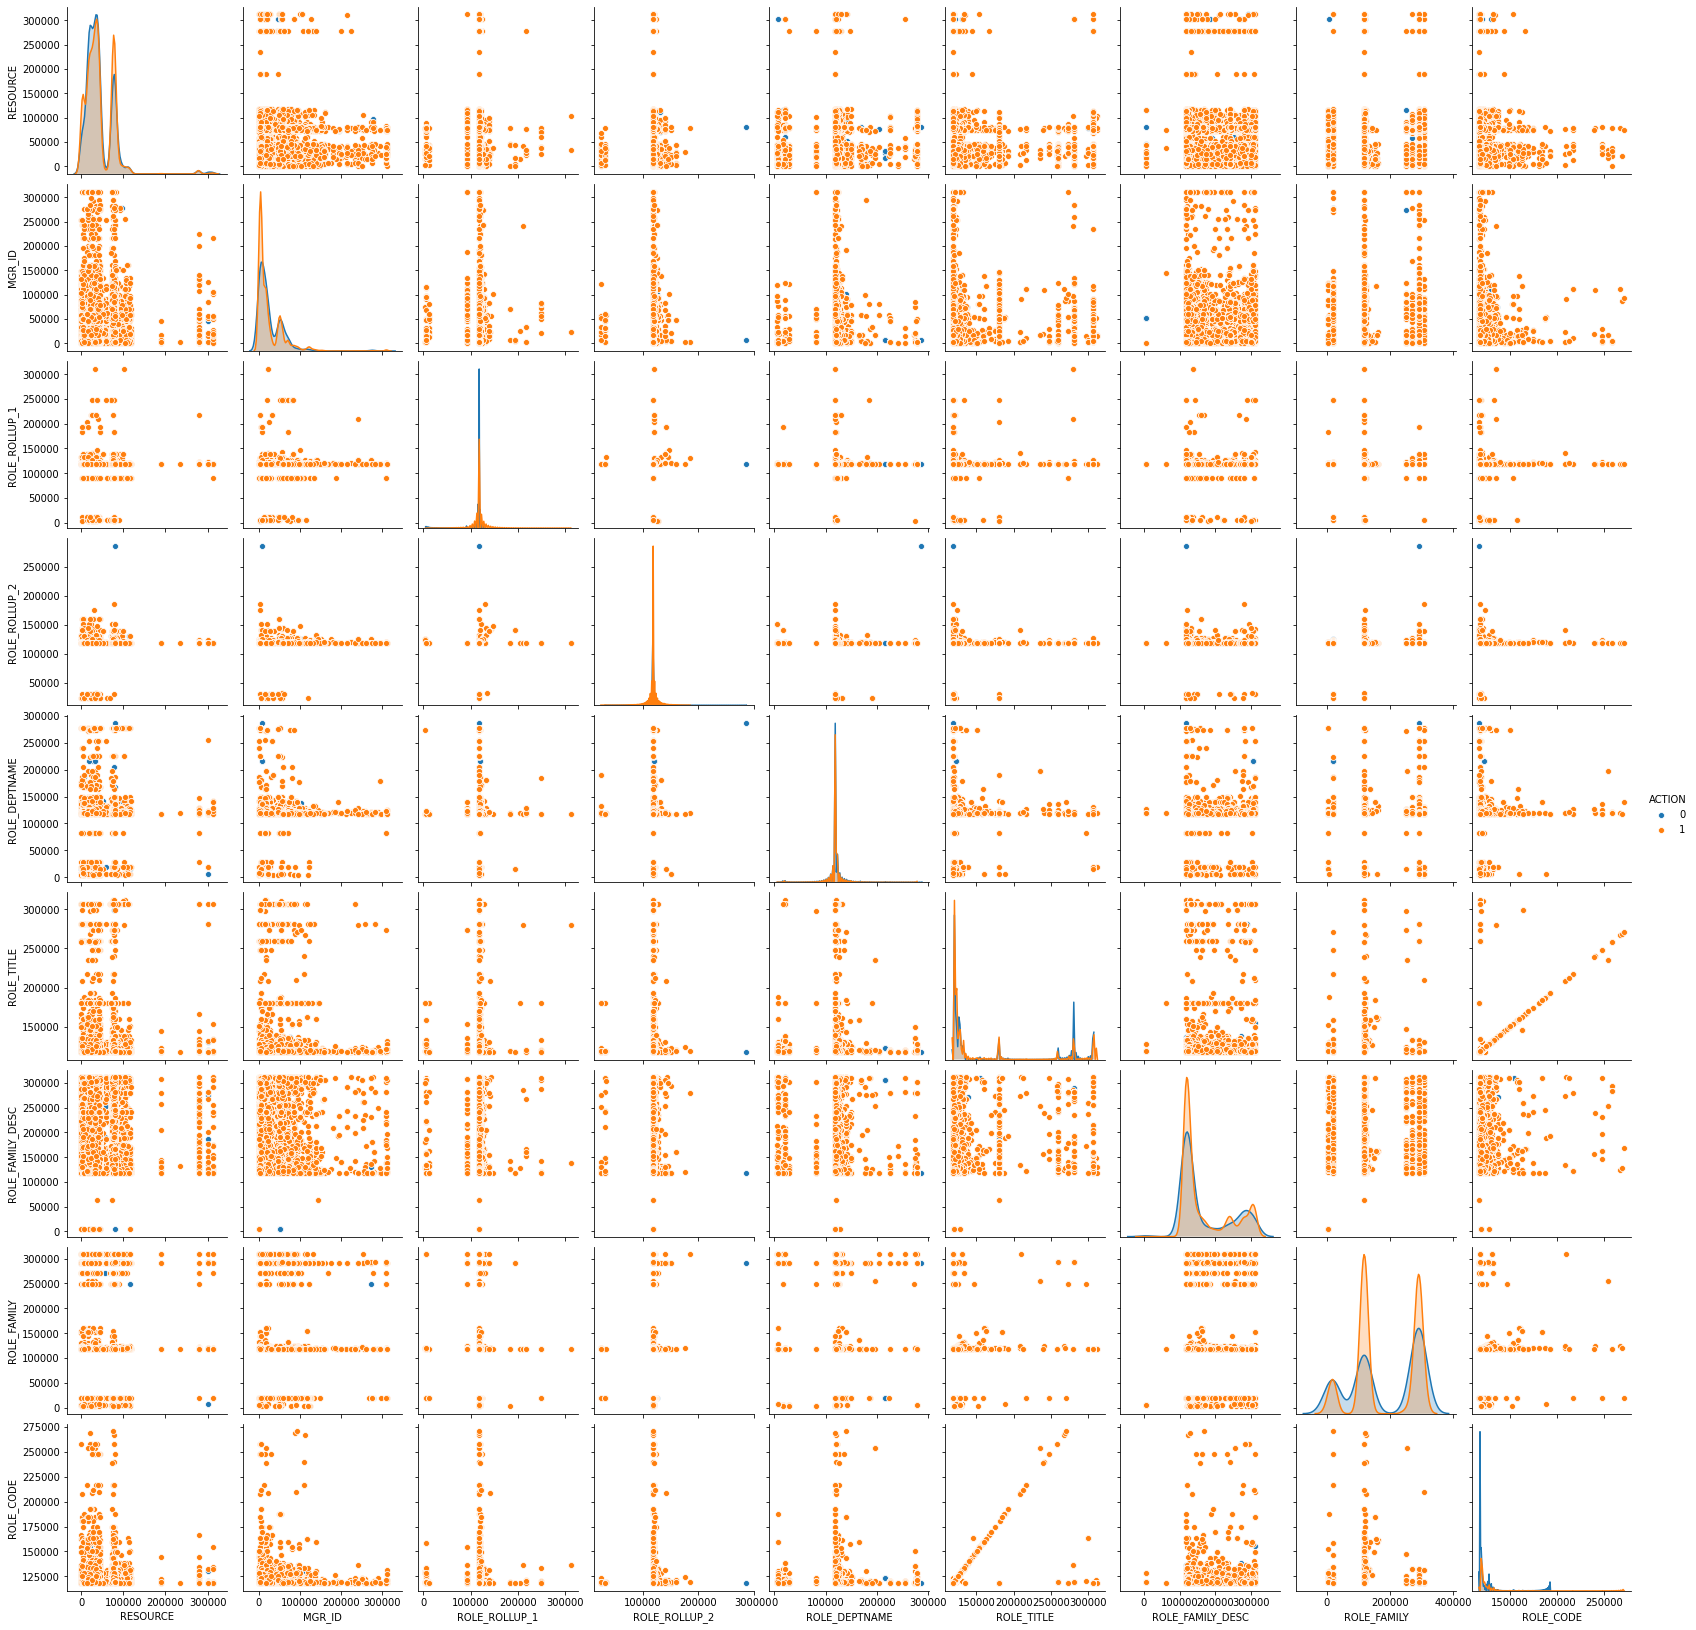

In [ ]:
#Lets plot a pairplot here
sns.pairplot(data, hue = 'ACTION')

Looks like we have covered everything worth noting here.

One major outcome to take forward in feature engineering is that we can safely remove one of the features either ROLE_CODE or ROLE_FAMILY since they are highly correlated.

#Feature Engineering

In [ ]:
Y = data['ACTION']
X = data.drop('ACTION', axis = 1)

#Dropping ROLE_CODE feature.
X = X.drop('ROLE_CODE', axis = 1)

X_test = data_test.drop('ROLE_CODE', axis = 1)
X_test = X_test.drop('id', axis = 1)

In [ ]:
X_test.head()

,RESOURCE,MGR_ID,ROLE_ROLLUP_1,ROLE_ROLLUP_2,ROLE_DEPTNAME,ROLE_TITLE,ROLE_FAMILY_DESC,ROLE_FAMILY
0,78766,72734,118079,118080,117878,117879,118177,19721
1,40644,4378,117961,118327,118507,118863,122008,118398
2,75443,2395,117961,118300,119488,118172,301534,249618
3,43219,19986,117961,118225,118403,120773,136187,118960
4,42093,50015,117961,118343,119598,118422,300136,118424


Since all the features in this challenge are categorical. So we will be trying various encoding techniques to encode categorical features. Lets define them first.

##1. Label Encoding

In [ ]:
from sklearn import preprocessing

def lab_enc(df_train, df_cv, column):
    le = preprocessing.LabelEncoder()
    le.fit(df_train[column])
    df_train_le = le.transform(df_train[column])
    df_cv[column] = df_cv[column].map(lambda s: 0 if s not in le.classes_ else s)
    le.classes_ = np.append(le.classes_, 0)
    df_cv_le = le.transform(df_cv[column])
    return df_train_le, df_cv_le

###2. Binary Encoding

In [ ]:
!pip install category-encoders

     |████████████████████████████████| 81kB 2.2MB/s 


In [ ]:
from category_encoders import BinaryEncoder

def bin_enc(X_train, Y_train, X_cv):
    binary_enc = BinaryEncoder(cols=X_train.columns).fit(X_train, Y_train)
    X_train_binary = binary_enc.transform(X_train.reset_index(drop=True))
    X_val_binary = binary_enc.transform(X_cv.reset_index(drop=True))
    return X_train_binary, X_val_binary

###3. One-Hot Encoding

In [ ]:
from sklearn.preprocessing import OneHotEncoder

def onehot_enc(df_train, df_cv):
    one_hot_enc = OneHotEncoder(sparse=True, handle_unknown = 'ignore')
    data_ohe_train = (one_hot_enc.fit_transform(df_train))
    data_ohe_val = (one_hot_enc.transform(df_cv))
    return data_ohe_train, data_ohe_val

###4. Frequency Encoding

In [ ]:
#Source: https://www.kaggle.com/bhavikapanara/frequency-encoding
def freq_enc(df_train, df_cv, column):
    train = (df_train.groupby(column).size()) / len(df_train)
    cv = (df_cv.groupby(column).size()) / len(df_cv)
    freq_enc_train = df_train[column].apply(lambda x : train[x])
    freq_enc_cv = df_cv[column].apply(lambda x : cv[x])
    return freq_enc_train, freq_enc_cv

###5. Feature Hashing

In [ ]:
def hash_enc(df_train, df_cv, n_components):
    hashing_enc = HashingEncoder(cols=df_train.columns, n_components=n_components).fit(X_train, Y_train)
        
    X_train_hashing = hashing_enc.transform(X_train.reset_index(drop=True))
    X_val_hashing = hashing_enc.transform(X_cv.reset_index(drop=True))
    return X_train_hashing, X_val_hashing

Let's try creating some additional features now

##Hybrid Features

Since these features are already encoded randomly and they are nominal features. So, adding, subtracting the feature values won't help much. However we can try concatenating them with each other. 

In [ ]:
n = len(X.columns)
print(f"We can {n} no. of features.")

We can 8 no. of features.


In [ ]:
from tqdm import tqdm
from itertools import combinations

def concat_features_duplet(df_train, cols):
    dup_features = []
    for indicies in combinations(range(len(cols)), 2):
        dup_features.append([hash(tuple(v)) for v in df_train[:,list(indicies)]])
    return np.array(dup_features).T

In [ ]:
def concat_features_triplet(df_train, cols):
    tri_features = []
    for indicies in combinations(range(len(cols)), 3):
        tri_features.append([hash(tuple(v)) for v in df_train[:,list(indicies)]])
    return np.array(tri_features).T

Let's add feature category frequencies as well.

In [ ]:
from collections import Counter

def category_freq(X):
    X_new = X.copy()
    for f in X_new.columns:
        col_count = dict(Counter(X_new[f].values))

        for r in X_new.itertuples():
            X_new.at[r[0], f'{f}_freq'] = col_count[X_new.loc[r[0], f]]
    return X_new

In [ ]:
X.nunique()

RESOURCE            7518
MGR_ID              4243
ROLE_ROLLUP_1        128
ROLE_ROLLUP_2        177
ROLE_DEPTNAME        449
ROLE_TITLE           343
ROLE_FAMILY_DESC    2358
ROLE_FAMILY           67
dtype: int64

In [ ]:
X_dup_train = concat_features_duplet(np.array(X), ['RESOURCE', 'MGR_ID', 'ROLE_ROLLUP_1', 'ROLE_ROLLUP_2', 'ROLE_DEPTNAME',
       'ROLE_TITLE', 'ROLE_FAMILY_DESC', 'ROLE_FAMILY'])

X_tri_train = concat_features_triplet(np.array(X), ['RESOURCE', 'MGR_ID', 'ROLE_ROLLUP_1', 'ROLE_ROLLUP_2', 'ROLE_DEPTNAME',
       'ROLE_TITLE', 'ROLE_FAMILY_DESC', 'ROLE_FAMILY'])

In [ ]:
X_dup_test = concat_features_duplet(np.array(X_test), ['RESOURCE', 'MGR_ID', 'ROLE_ROLLUP_1', 'ROLE_ROLLUP_2', 'ROLE_DEPTNAME',
       'ROLE_TITLE', 'ROLE_FAMILY_DESC', 'ROLE_FAMILY'])

X_tri_test = concat_features_triplet(np.array(X_test), ['RESOURCE', 'MGR_ID', 'ROLE_ROLLUP_1', 'ROLE_ROLLUP_2', 'ROLE_DEPTNAME',
       'ROLE_TITLE', 'ROLE_FAMILY_DESC', 'ROLE_FAMILY'])

In [ ]:
from sklearn.preprocessing import LabelEncoder

X_dup_all = np.vstack((X_dup_train, X_dup_test))
X_tri_all = np.vstack((X_tri_train, X_tri_test))

le = LabelEncoder()
for i in range(X_dup_train.shape[1]):
  le.fit(X_dup_all[:, i])
  X_dup_train[:, i] = le.transform(X_dup_train[:, i])
  X_dup_test[:, i] = le.transform(X_dup_test[:, i])

for j in range(X_tri_train.shape[1]):
  le.fit(X_tri_all[:, j])
  X_tri_train[:, j] = le.transform(X_tri_train[:, j])
  X_tri_test[:, j] = le.transform(X_tri_test[:, j])

In [ ]:
X_dup_train.shape

(32769, 28)

In [ ]:
X_freq_train = np.array(category_freq(X).iloc[:,8:])
X_freq_test = np.array(category_freq(X_test).iloc[:,8:])

In [ ]:
X_freq_train.shape

(32769, 8)

Combining all the original features + hybrid categorical features

In [ ]:
X_train_all_categorical = np.hstack((X, X_dup_train, X_tri_train))
X_test_all_categorical = np.hstack((X_test, X_dup_test, X_tri_test))

In [ ]:
X_train_all_categorical.shape

(32769, 92)

###One-Hot Encoding all categorical variables

In [ ]:
from sklearn.preprocessing import OneHotEncoder

one_hot = OneHotEncoder()
one_hot.fit(np.vstack((X_train_all_categorical, X_test_all_categorical)))
X_train_cat_one_enc = one_hot.transform(X_train_all_categorical)
X_test_cat_one_enc = one_hot.transform(X_test_all_categorical)

In [ ]:
X_train_cat_one_enc

<32769x1595082 sparse matrix of type '<class 'numpy.float64'>'
	with 3014748 stored elements in Compressed Sparse Row format>

###Standard Scaler for Numerical Features

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(np.vstack((X_freq_train, X_freq_test)))

X_train_freq = scaler.transform(X_freq_train)
X_test_freq = scaler.transform(X_freq_test)

In [ ]:
X_train_freq.shape

(32769, 8)

###Thats all. We will have a lots of options to try with all these different encodings and hybrid features. Let's jump into the interesting part i.e. Modelling!

#Modelling-

BEWARE! Below Content is not meant for 'light-hearted' computers. Its going to be brutal.

My approach here would be to go on an expedition to find the set of most useful features out of all the feature engineered features. And then passing these features to a highly tuned and fairly advanced machine learning model. Hopefully! All this should result in a decent AUC score.

Let's first set a high benchmark AUC with the help of a base model.

##Base Model

We will be trying Logistic Regression as the base model. Since, it is a simple technique and works fairly well with categorical data.

In [ ]:
#Train Test Split
from sklearn.model_selection import train_test_split
X_train, X_cv, Y_train, Y_cv = train_test_split(X, Y, stratify = Y, test_size = 0.2)

Let's use all encodings now.

In [ ]:
#Label Encoding
X_train_lab_enc = {}
X_cv_lab_enc = {}

for i in X_train.columns:
    X_train_lab_enc[i], X_cv_lab_enc[i] = lab_enc(X_train, X_cv, i)

X_cv_lab_enc = pd.DataFrame(X_cv_lab_enc)
X_train_lab_enc = pd.DataFrame(X_train_lab_enc)

In [ ]:
#Binary Encoding
X_train_bin_enc, X_cv_bin_enc = bin_enc(X_train, Y_train, X_cv)

In [ ]:
#One-Hot Encoding
X_train_one_enc, X_cv_one_enc = onehot_enc(X_train, X_cv)

In [ ]:
#Frequency Encoding
X_train_freq_enc = {}
X_cv_freq_enc = {}

for i in X_train.columns:
    X_train_freq_enc[i], X_cv_freq_enc[i] = freq_enc(X_train, X_cv, i)

X_cv_freq_enc = pd.DataFrame(X_cv_freq_enc)
X_train_freq_enc = pd.DataFrame(X_train_freq_enc)

In [ ]:
from category_encoders.hashing import HashingEncoder

#Hashing Trick
X_train_hash_enc, X_cv_hash_enc = hash_enc(X_train, X_cv, 1000)

###Logistic Regression

Fitting Logistic Regression Model with Hyper-Parameter Tuning on all the encodings.

For C = 0.0001: AUC = 0.599694273231282
For C = 0.001: AUC = 0.5996088150150086
For C = 0.01: AUC = 0.599594287118242
For C = 0.1: AUC = 0.5995985600290559
For C = 1.0: AUC = 0.5995921506628352
For C = 10: AUC = 0.5996006964844626
For C = 100: AUC = 0.5996015510666255
For C = 1000: AUC = 0.599601123775544
For C = 10000: AUC = 0.599601123775544
For C = 100000: AUC = 0.599601123775544


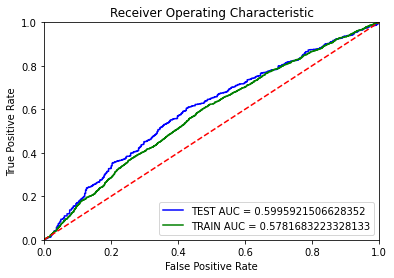

In [ ]:
#label encoder
from sklearn.linear_model import LogisticRegression
import sklearn.metrics as metrics

C = [10e-5, 10e-4, 10e-3, 10e-2, 10e-1, 10, 100, 1000, 10000, 100000]

for i in C:
    clf = LogisticRegression(C= i, class_weight= 'balanced',  max_iter=1000)
    clf.fit(X_train_lab_enc, Y_train)

    # calculate the fpr and tpr for all thresholds of the classification
    probs_te = clf.predict_proba(X_cv_lab_enc)
    preds_te = probs_te[:,1]
    fpr_te, tpr_te, threshold_te = metrics.roc_curve(Y_cv, preds_te)
    roc_auc_te = metrics.auc(fpr_te, tpr_te)
    probs_tr = clf.predict_proba(X_train_lab_enc)
    preds_tr = probs_tr[:,1]
    fpr_tr, tpr_tr, threshold_tr = metrics.roc_curve(Y_train, preds_tr)
    roc_auc_tr = metrics.auc(fpr_tr, tpr_tr)

    print(f'For C = {i}: AUC = {roc_auc_te}')


clf = LogisticRegression(C= 1, class_weight= 'balanced')
clf.fit(X_train_lab_enc, Y_train)

# calculate the fpr and tpr for all thresholds of the classification
probs_te = clf.predict_proba(X_cv_lab_enc)
preds_te = probs_te[:,1]
fpr_te, tpr_te, threshold_te = metrics.roc_curve(Y_cv, preds_te)
roc_auc_te = metrics.auc(fpr_te, tpr_te)
probs_tr = clf.predict_proba(X_train_lab_enc)
preds_tr = probs_tr[:,1]
fpr_tr, tpr_tr, threshold_tr = metrics.roc_curve(Y_train, preds_tr)
roc_auc_tr = metrics.auc(fpr_tr, tpr_tr)

import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr_te, tpr_te, 'b', label = f'TEST AUC = {roc_auc_te}')
plt.plot(fpr_tr, tpr_tr, 'g', label = f'TRAIN AUC = {roc_auc_tr}')
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

For C = 0.001: AUC = 0.6178661083396536
For C = 0.01: AUC = 0.614938737141209
For C = 0.1: AUC = 0.6126360655037228
For C = 1.0: AUC = 0.6122955145118734
For C = 10: AUC = 0.6122946599297105
For C = 100: AUC = 0.6122869686902459
For C = 1000: AUC = 0.6122562037323875
For C = 10000: AUC = 0.6122797047418629


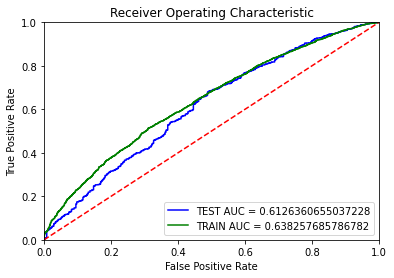

In [ ]:
#binary encoder
from sklearn.linear_model import LogisticRegression
import sklearn.metrics as metrics

C = [10e-4, 10e-3, 10e-2, 10e-1, 10, 100, 1000, 10000]

for i in C:
    clf = LogisticRegression(C= i, class_weight= 'balanced',  max_iter=5000)
    clf.fit(X_train_bin_enc, Y_train)

    # calculate the fpr and tpr for all thresholds of the classification
    probs_te = clf.predict_proba(X_cv_bin_enc)
    preds_te = probs_te[:,1]
    fpr_te, tpr_te, threshold_te = metrics.roc_curve(Y_cv, preds_te)
    roc_auc_te = metrics.auc(fpr_te, tpr_te)
    probs_tr = clf.predict_proba(X_train_bin_enc)
    preds_tr = probs_tr[:,1]
    fpr_tr, tpr_tr, threshold_tr = metrics.roc_curve(Y_train, preds_tr)
    roc_auc_tr = metrics.auc(fpr_tr, tpr_tr)

    print(f'For C = {i}: AUC = {roc_auc_te}')


clf = LogisticRegression(C= 0.1, class_weight= 'balanced',  max_iter=5000)
clf.fit(X_train_bin_enc, Y_train)

# calculate the fpr and tpr for all thresholds of the classification
probs_te = clf.predict_proba(X_cv_bin_enc)
preds_te = probs_te[:,1]
fpr_te, tpr_te, threshold_te = metrics.roc_curve(Y_cv, preds_te)
roc_auc_te = metrics.auc(fpr_te, tpr_te)
probs_tr = clf.predict_proba(X_train_bin_enc)
preds_tr = probs_tr[:,1]
fpr_tr, tpr_tr, threshold_tr = metrics.roc_curve(Y_train, preds_tr)
roc_auc_tr = metrics.auc(fpr_tr, tpr_tr)

import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr_te, tpr_te, 'b', label = f'TEST AUC = {roc_auc_te}')
plt.plot(fpr_tr, tpr_tr, 'g', label = f'TRAIN AUC = {roc_auc_tr}')
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

For C = 0.001: AUC = 0.7134686421757662
For C = 0.01: AUC = 0.7910288101011611
For C = 0.1: AUC = 0.8435569846068388
For C = 1.0: AUC = 0.8497565509063911
For C = 10: AUC = 0.8378923867411576
For C = 100: AUC = 0.817632380118146
For C = 1000: AUC = 0.8006355954835332
For C = 10000: AUC = 0.789202568019399


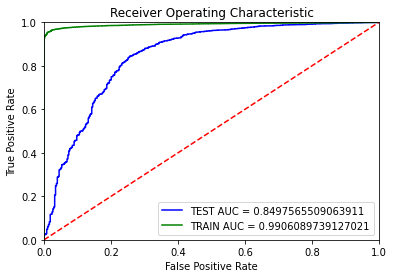

In [ ]:
#one-hot encoder
from sklearn.linear_model import LogisticRegression
import sklearn.metrics as metrics

C = [10e-4, 10e-3, 10e-2, 10e-1, 10, 100, 1000, 10000]

for i in C:
    clf = LogisticRegression(C= i, class_weight= 'balanced',  max_iter=5000)
    clf.fit(X_train_one_enc, Y_train)

    # calculate the fpr and tpr for all thresholds of the classification
    probs_te = clf.predict_proba(X_cv_one_enc)
    preds_te = probs_te[:,1]
    fpr_te, tpr_te, threshold_te = metrics.roc_curve(Y_cv, preds_te)
    roc_auc_te = metrics.auc(fpr_te, tpr_te)
    probs_tr = clf.predict_proba(X_train_one_enc)
    preds_tr = probs_tr[:,1]
    fpr_tr, tpr_tr, threshold_tr = metrics.roc_curve(Y_train, preds_tr)
    roc_auc_tr = metrics.auc(fpr_tr, tpr_tr)

    print(f'For C = {i}: AUC = {roc_auc_te}')

clf = LogisticRegression(C= 1, class_weight= 'balanced',  max_iter=5000)
clf.fit(X_train_one_enc, Y_train)

# calculate the fpr and tpr for all thresholds of the classification
probs_te = clf.predict_proba(X_cv_one_enc)
preds_te = probs_te[:,1]
fpr_te, tpr_te, threshold_te = metrics.roc_curve(Y_cv, preds_te)
roc_auc_te = metrics.auc(fpr_te, tpr_te)
probs_tr = clf.predict_proba(X_train_one_enc)
preds_tr = probs_tr[:,1]
fpr_tr, tpr_tr, threshold_tr = metrics.roc_curve(Y_train, preds_tr)
roc_auc_tr = metrics.auc(fpr_tr, tpr_tr)

import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr_te, tpr_te, 'b', label = f'TEST AUC = {roc_auc_te}')
plt.plot(fpr_tr, tpr_tr, 'g', label = f'TRAIN AUC = {roc_auc_tr}')
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

For C = 0.0001: AUC = 0.5885592812964011
For C = 0.001: AUC = 0.5855387606422184
For C = 0.01: AUC = 0.5875102816916453
For C = 0.1: AUC = 0.589544187238952
For C = 1.0: AUC = 0.5727072094687704
For C = 10: AUC = 0.5686620448014699
For C = 100: AUC = 0.5657141636311196
For C = 1000: AUC = 0.5647484857872304
For C = 10000: AUC = 0.5646267078290408
For C = 100000: AUC = 0.5646301261576918


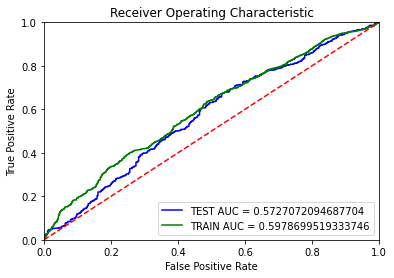

In [ ]:
#frequency encoder
from sklearn.linear_model import LogisticRegression
import sklearn.metrics as metrics

C = [10e-5, 10e-4, 10e-3, 10e-2, 10e-1, 10, 100, 1000, 10000, 100000]

for i in C:
    clf = LogisticRegression(C= i, class_weight= 'balanced', max_iter=1000)
    clf.fit(X_train_freq_enc, Y_train)

    # calculate the fpr and tpr for all thresholds of the classification
    probs_te = clf.predict_proba(X_cv_freq_enc)
    preds_te = probs_te[:,1]
    fpr_te, tpr_te, threshold_te = metrics.roc_curve(Y_cv, preds_te)
    roc_auc_te = metrics.auc(fpr_te, tpr_te)
    probs_tr = clf.predict_proba(X_train_freq_enc)
    preds_tr = probs_tr[:,1]
    fpr_tr, tpr_tr, threshold_tr = metrics.roc_curve(Y_train, preds_tr)
    roc_auc_tr = metrics.auc(fpr_tr, tpr_tr)

    print(f'For C = {i}: AUC = {roc_auc_te}')

clf = LogisticRegression(C= 1, class_weight= 'balanced')
clf.fit(X_train_freq_enc, Y_train)

# calculate the fpr and tpr for all thresholds of the classification
probs_te = clf.predict_proba(X_cv_freq_enc)
preds_te = probs_te[:,1]
fpr_te, tpr_te, threshold_te = metrics.roc_curve(Y_cv, preds_te)
roc_auc_te = metrics.auc(fpr_te, tpr_te)
probs_tr = clf.predict_proba(X_train_freq_enc)
preds_tr = probs_tr[:,1]
fpr_tr, tpr_tr, threshold_tr = metrics.roc_curve(Y_train, preds_tr)
roc_auc_tr = metrics.auc(fpr_tr, tpr_tr)

import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr_te, tpr_te, 'b', label = f'TEST AUC = {roc_auc_te}')
plt.plot(fpr_tr, tpr_tr, 'g', label = f'TRAIN AUC = {roc_auc_tr}')
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

For C = 0.0001: AUC = 0.6953002253960454
For C = 0.001: AUC = 0.7236526978090649
For C = 0.01: AUC = 0.7732124811724868
For C = 0.1: AUC = 0.786080352087851
For C = 1.0: AUC = 0.7746238236142416
For C = 10: AUC = 0.7671740036106096
For C = 100: AUC = 0.764450450257977
For C = 1000: AUC = 0.7633531667610267
For C = 10000: AUC = 0.7630207342997233
For C = 100000: AUC = 0.7629839872667258


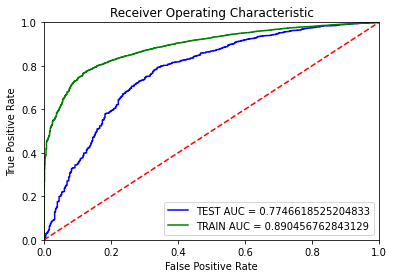

In [ ]:
#hashing encoder
from sklearn.linear_model import LogisticRegression
import sklearn.metrics as metrics

C = [10e-5, 10e-4, 10e-3, 10e-2, 10e-1, 10, 100, 1000, 10000, 100000]

for i in C:
    clf = LogisticRegression(C= i, class_weight= 'balanced',  max_iter=1000)
    clf.fit(X_train_hash_enc, Y_train)

    # calculate the fpr and tpr for all thresholds of the classification
    probs_te = clf.predict_proba(X_cv_hash_enc)
    preds_te = probs_te[:,1]
    fpr_te, tpr_te, threshold_te = metrics.roc_curve(Y_cv, preds_te)
    roc_auc_te = metrics.auc(fpr_te, tpr_te)
    probs_tr = clf.predict_proba(X_train_hash_enc)
    preds_tr = probs_tr[:,1]
    fpr_tr, tpr_tr, threshold_tr = metrics.roc_curve(Y_train, preds_tr)
    roc_auc_tr = metrics.auc(fpr_tr, tpr_tr)

    print(f'For C = {i}: AUC = {roc_auc_te}')

clf = LogisticRegression(C= 1, class_weight= 'balanced')
clf.fit(X_train_hash_enc, Y_train)

# calculate the fpr and tpr for all thresholds of the classification
probs_te = clf.predict_proba(X_cv_hash_enc)
preds_te = probs_te[:,1]
fpr_te, tpr_te, threshold_te = metrics.roc_curve(Y_cv, preds_te)
roc_auc_te = metrics.auc(fpr_te, tpr_te)
probs_tr = clf.predict_proba(X_train_hash_enc)
preds_tr = probs_tr[:,1]
fpr_tr, tpr_tr, threshold_tr = metrics.roc_curve(Y_train, preds_tr)
roc_auc_tr = metrics.auc(fpr_tr, tpr_tr)

import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr_te, tpr_te, 'b', label = f'TEST AUC = {roc_auc_te}')
plt.plot(fpr_tr, tpr_tr, 'g', label = f'TRAIN AUC = {roc_auc_tr}')
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

The above results show that Logistic Regression with One-Hot Encoding is working fairly well. We are getting best AUC =  0.8497 from one-hot encoding.

In [ ]:
from prettytable import PrettyTable
x = PrettyTable()

x.field_names = ["Model", "Encoding Technique", "AUC"]

x.add_row(["Logistic Regression", "Label Encoding", 0.5996])
x.add_row(["Logistic Regression", "Binary Encoding", 0.6178])
x.add_row(["Logistic Regression", "One-Hot Encoding", 0.8497])
x.add_row(["Logistic Regression", "Frequency Encoding", 0.5890])
x.add_row(["Logistic Regression", "Hash Encoding", 0.7860])
print(x)

+---------------------+--------------------+--------+
|        Model        | Encoding Technique |  AUC   |
+---------------------+--------------------+--------+
| Logistic Regression |   Label Encoding   | 0.5996 |
| Logistic Regression |  Binary Encoding   | 0.6178 |
| Logistic Regression |  One-Hot Encoding  | 0.8497 |
| Logistic Regression | Frequency Encoding | 0.589  |
| Logistic Regression |   Hash Encoding    | 0.786  |
+---------------------+--------------------+--------+


**Base Model Best AUC Score: 0.8497**